We've seen that when using a word dataset with word counts we could design a spam filter, not brilliant but not terrible either. In this notebook however we'll look at the case where we are handled trainig data with complete emails instead.

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, model_selection, metrics, naive_bayes, linear_model, feature_extraction 
import matplotlib.pyplot as plt 
import seaborn as sb
import nltk
import re
import unicodedata
import itertools
import os

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Fredrik
[nltk_data]     Gustafsson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Fredrik
[nltk_data]     Gustafsson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [3]:
current_folder = os.getcwd()
data = pd.read_csv(current_folder + '/data/fraud_email.csv')
data = data.dropna()
print(data.head(5))
print(data.shape)
print(data.loc[:,'Class'].sum())

                                                Text  Class
0  Supply Quality China's EXCLUSIVE dimensions at...      1
1                         over. SidLet me know. Thx.      0
2  Dear Friend,Greetings to you.I wish to accost ...      1
3  MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....      1
4          Not a surprising assessment from Embassy.      0
(11928, 2)
5186


This file then contains 11928 emails out of which 5186 are classified as spam mails. Each row appears to consiste of tw columns one with the texg and one containig the label. We'll start with splitting the data into a test set and one training set. After which we'll see how balanced the dataset is.

In [4]:
target = data.pop('Class')
data_train, data_test, target_train, target_test = model_selection.train_test_split(data, target, test_size=0.2, random_state=42)

(4122, 2)
(5420, 2)


C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<Figure size 720x360 with 0 Axes>

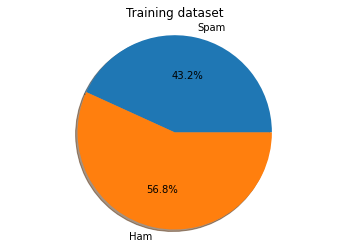

(1064, 2)
(1322, 2)


C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 720x360 with 0 Axes>

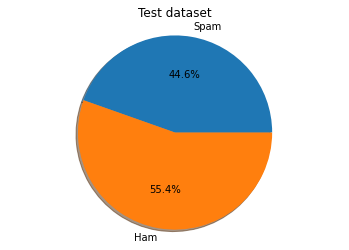

In [5]:
tmp_train = data_train
tmp_train['Class'] = target_train
tmp_data_spam = tmp_train.loc[tmp_train['Class'] == 1]
tmp_data_ham = tmp_train.loc[tmp_train['Class'] == 0]

plt.figure(1, figsize=(10,5))
print(tmp_data_spam.shape)
print(tmp_data_ham.shape)
labels = ['Spam', 'Ham']
number = [len(tmp_data_spam), len(tmp_data_ham)]
fig1, ax1 = plt.subplots()
ax1.pie(number, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title = 'Training dataset') 
plt.show()

tmp_test = data_test
tmp_test['Class'] = target_test
tmp_data_spam_test = tmp_test.loc[tmp_test['Class'] == 1]
tmp_data_ham_test = tmp_test.loc[tmp_test['Class'] == 0]

plt.figure(1, figsize=(10,5))
print(tmp_data_spam_test.shape)
print(tmp_data_ham_test.shape)
labels = ['Spam', 'Ham']
number = [len(tmp_data_spam_test), len(tmp_data_ham_test)]
fig1, ax1 = plt.subplots()
ax1.pie(number, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title = 'Test dataset') 
plt.show()

As we can see the datasets are fairly balanced with a bit less spam mails compared to real. Next we'll look at the most common words.

In [6]:
tmp_common_words = data_train.Text.str.split(expand=True).stack().value_counts().head(20)

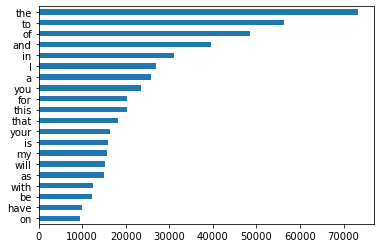

In [7]:
tmp_common_words.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()

Remove stopwords use previous experience to remove more, potential, stopwords in this case we return the data as a list due to us then being able to show most common bigrams and trigrams easily. 

In [8]:
def cleaning(text):
    nltk_s_words = nltk.corpus.stopwords.words('english')
    additional_s_words = ['th', 'en', 'ct', 'hou', 'ect']
    stop_words = nltk_s_words + additional_s_words
    text = (unicodedata.normalize('NFKD', text)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())

    wnl = nltk.stem.WordNetLemmatizer()
    words_in_mail = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words_in_mail if word not in stop_words]


In [9]:
words = cleaning(data_train.Text.to_string())

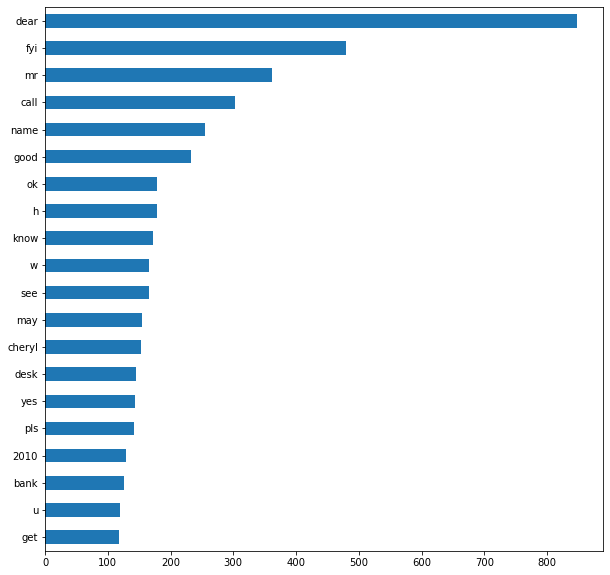

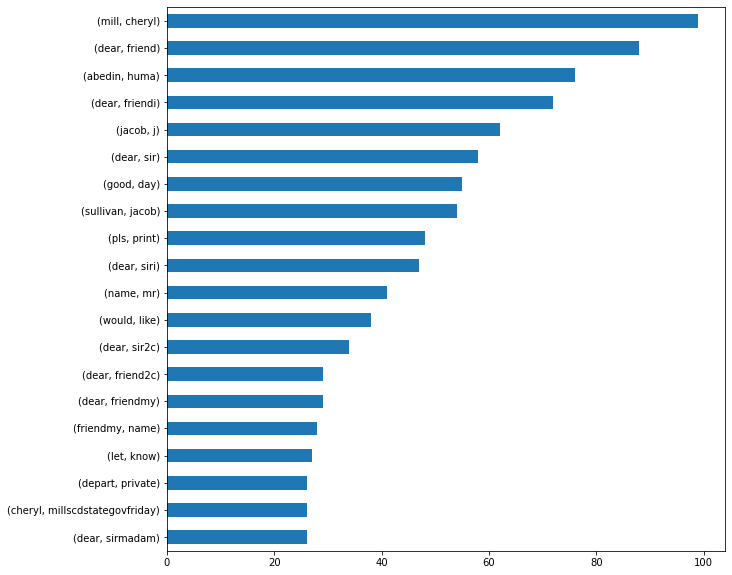

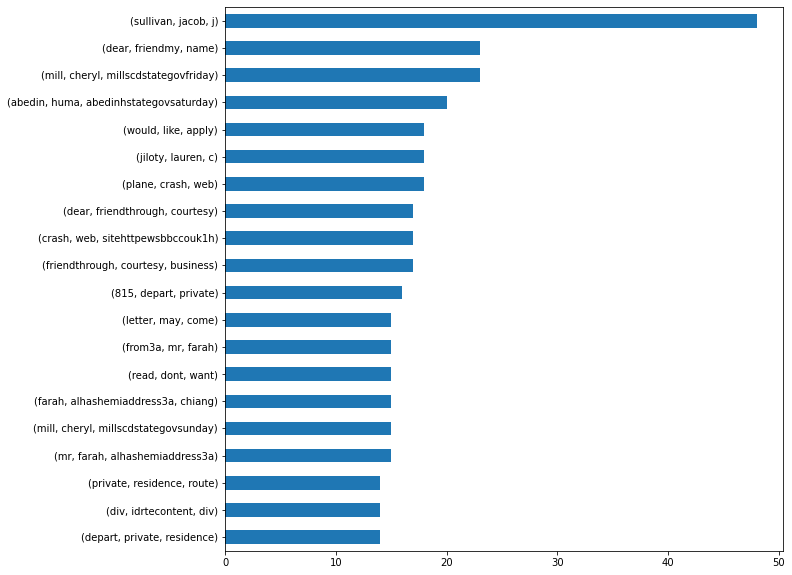

In [10]:
words_series = pd.Series(words)
tmp_common_words = words_series.str.split(expand=True).stack().value_counts().head(20)
bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:20]
trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:20]

plt.figure(1, figsize=(10,10))
tmp_common_words.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(2, figsize=(10,10))
bigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(3, figsize=(10,10))
trigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

As we can see the word "dear" is among the most common words to be either found on its own or in the most common combinations od both two or three words. One interesting thing is the combination "sullivan", "jacob", "j" which might either be someone who is mentioned in emails or more likely from someone who signs their email with their name.

In [11]:
data_train['Class'] = target_train
data_spam = data_train.loc[data_train['Class'] == 1]
data_ham = data_train.loc[data_train['Class'] == 0]

C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
spam_words = cleaning(data_spam.Text.to_string())
ham_words = cleaning(data_ham.Text.to_string())

spam_words_series = pd.Series(spam_words)
spam_common_words = spam_words_series.str.split(expand=True).stack().value_counts().head(20)
spam_bigram = (pd.Series(nltk.ngrams(spam_words, 2)).value_counts())[:20]
spam_trigram = (pd.Series(nltk.ngrams(spam_words, 3)).value_counts())[:20]

ham_words_series = pd.Series(ham_words)
ham_common_words = ham_words_series.str.split(expand=True).stack().value_counts().head(20)
ham_bigram = (pd.Series(nltk.ngrams(ham_words, 2)).value_counts())[:20]
ham_trigram = (pd.Series(nltk.ngrams(ham_words, 3)).value_counts())[:20]

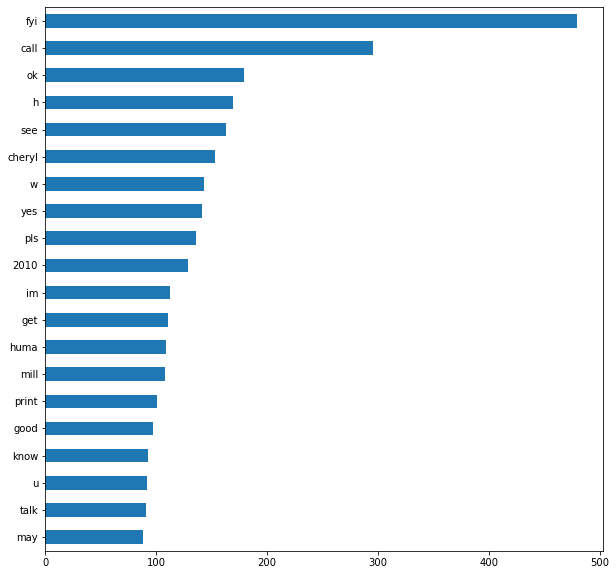

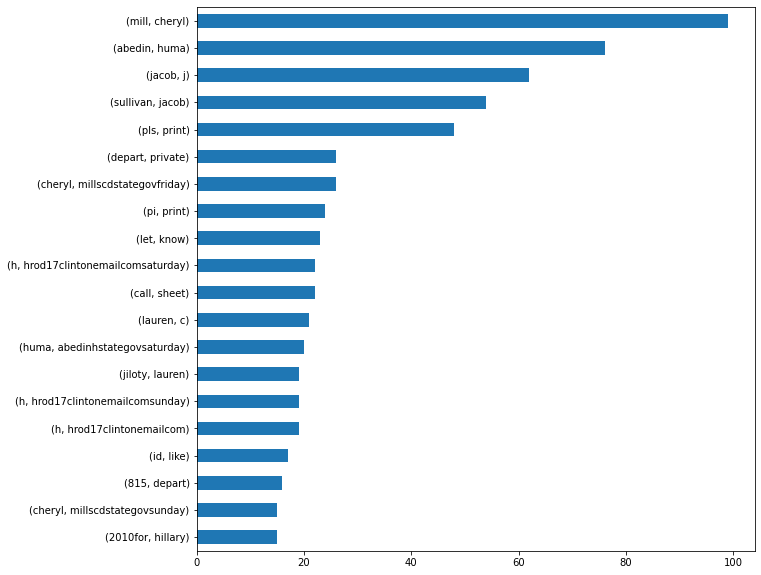

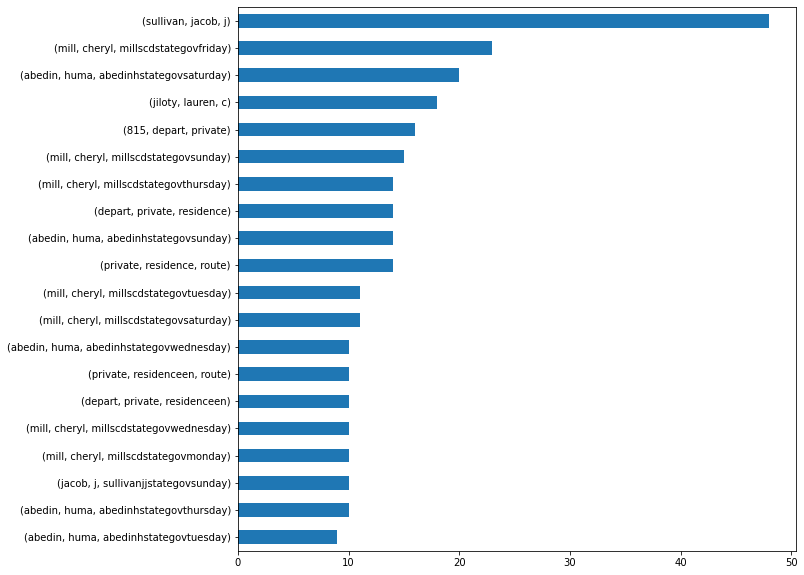

In [13]:
plt.figure(1, figsize=(10,10))
ham_common_words.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(2, figsize=(10,10))
ham_bigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(3, figsize=(10,10))
ham_trigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

When looking at the legit mails the same name combination is among the most common trigrams however it also appears together with stategovsunday. Whats interesting is that we have more names in combination with stategov this most likely means that said persons have had some sort of possition connected with the US state.

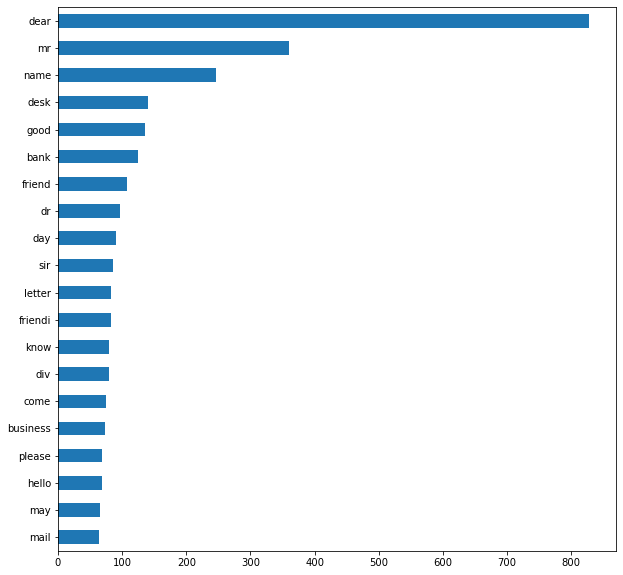

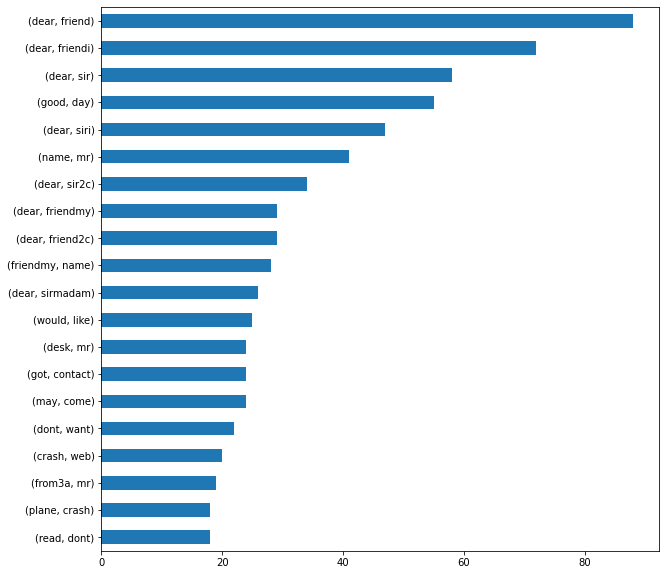

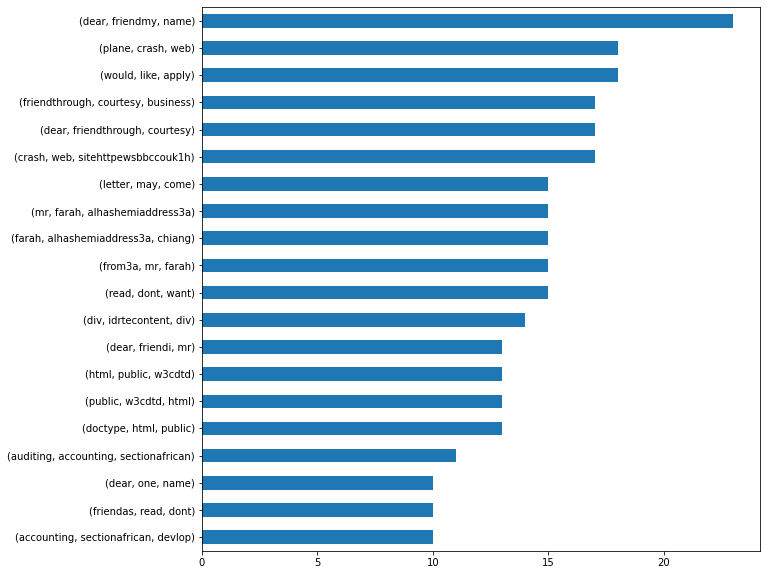

In [14]:
plt.figure(1, figsize=(10,10))
spam_common_words.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(2, figsize=(10,10))
spam_bigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

plt.figure(3, figsize=(10,10))
spam_trigram.plot(kind = 'barh')
ax = plt.gca()
ax.invert_yaxis()
plt.show()

On the other hand for spam mails the word "dear" is really common 8 out of 20 bigrams includes it.

In [15]:
pd.Series(words)

0             9712
1             dear
2          friendi
3        apologize
4          content
           ...    
48343          nom
48344          est
48345         mona
48346       khalil
48347           je
Length: 48348, dtype: object

We previously cleaned text and returned it as a list. In the code below we do the same thing but keep it as a frame instead which will allow us to get the tf-idf support of each word which basically tries to capture how important a word is across documents

In [16]:
def word_lemmatizer(words):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(o) for o in words]

In [17]:
nltk_s_words = nltk.corpus.stopwords.words('english')
additional_s_words = ['th', 'en', 'ct', 'hou', 'ect']
stop_words = nltk_s_words + additional_s_words
data_train['Text'] = data_train['Text'].apply(lambda x: [item for item in x.split() if item not in stop_words])
data_train['Text'] = data_train['Text'].apply(word_lemmatizer)
data_train['Text']=[" ".join(item) for item in data_train['Text'].values]

C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [18]:
vector = feature_extraction.text.TfidfVectorizer()
train_features = vector.fit_transform(data_train['Text'])

At this stage is where we would apply some feature selection algorithm since the number of features, and thereby memory usage, will be large, though we have to keep in mind that we can not use any sort of dimensionallity reduction since we have not yet converted the test data using the features. However for this notebook we will not do this since it's not the focus of it.

In [19]:
data_test['Text'] = data_test['Text'].apply(lambda x: [item for item in x.split() if item not in stop_words])
data_test['Text'] = data_test['Text'].apply(word_lemmatizer)
data_test['Text']=[" ".join(review) for review in data_test['Text'].values]
test_features = vector.transform(data_test['Text'])

C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Fredrik Gustafsson\Anaconda3\envs\Machine Learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [20]:
def confusion_matrix_plot(matrix, classes, normalize):
    if normalize == 1:
        matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]
    plt.imshow(matrix, interpolation = 'nearest', cmap = plt.cm.Blues)
    plt.title('Confussion matrix')
    plt.colorbar()
    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation=45)
    plt.yticks(marks, classes)

    fmt = '.2f' if normalize else 'd'
    threshold = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

A common model for detecting spam is the naive bayes classifier so we will start with it and compare it with random forest and linear regression

In [21]:
bayes = naive_bayes.GaussianNB()
bayes.fit(train_features.toarray(),target_train)
bayes_train_score = bayes.score(train_features.toarray(), target_train)
bayes_test_score = bayes.score(test_features.toarray(), target_test)
print("Training accuracy: ", bayes_train_score)
print("Test accuracy: ", bayes_test_score)

Training accuracy:  0.9994760008383986
Test accuracy:  0.9790444258172674


In [22]:
scores = model_selection.cross_val_score(bayes, train_features.toarray(), target_train, cv=10) #Do cross validation
print("\n Cross validation score: \n")
print(scores) #Report scores of cross validation
print("\n Mean cv score: ", np.mean(scores))


 Cross validation score: 

[0.98010471 0.96858639 0.98427673 0.9769392  0.97589099 0.97379455
 0.97274633 0.97274633 0.97589099 0.98218029]

 Mean cv score:  0.9763156508281472


Precision:  0.9677121771217713
Recall:  0.9859022556390977


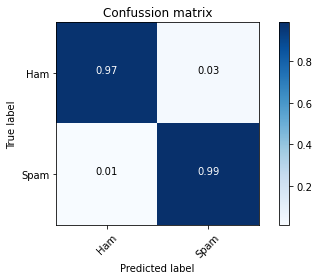

In [23]:
target_predict = bayes.predict(test_features.toarray())
plt.figure()
confusion_matrix_plot(metrics.confusion_matrix(target_test, target_predict), ['Ham', 'Spam'], 1)
tn, fp, fn, tp = metrics.confusion_matrix(target_test,target_predict).ravel()
print('Precision: ', tp / (tp + fp))
print('Recall: ', tp / (tp + fn))

Training accuracy:  0.9997904003353595
Test accuracy:  0.9865884325230512
Precision:  0.9952015355086372
Recall:  0.974624060150376


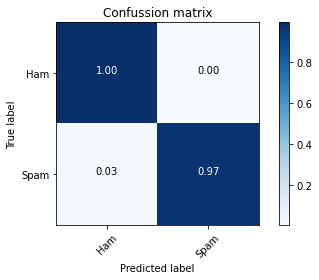

In [24]:
random_forest = ensemble.RandomForestClassifier()
random_forest.fit(train_features.toarray(),target_train)
rf_train_score = random_forest.score(train_features.toarray(), target_train)
rf_test_score = random_forest.score(test_features.toarray(), target_test)
print("Training accuracy: ", rf_train_score)
print("Test accuracy: ", rf_test_score)

target_predict = random_forest.predict(test_features.toarray())
plt.figure()
confusion_matrix_plot(metrics.confusion_matrix(target_test, target_predict), ['Ham', 'Spam'], 1)
tn, fp, fn, tp = metrics.confusion_matrix(target_test,target_predict).ravel()
print('Precision: ', tp / (tp + fp))
print('Recall: ', tp / (tp + fn))

Training accuracy:  0.9997904003353595
Test accuracy:  0.9865884325230512
Precision:  1.0
Recall:  0.9605263157894737


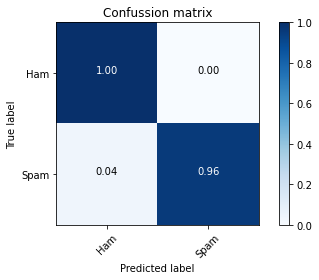

In [25]:
lr = linear_model.LogisticRegression()
lr.fit(train_features.toarray(), target_train)
lr_train_score = random_forest.score(train_features.toarray(), target_train)
lr_test_score = random_forest.score(test_features.toarray(), target_test)
print("Training accuracy: ", lr_train_score)
print("Test accuracy: ", lr_test_score)

target_predict = lr.predict(test_features.toarray())
plt.figure()
confusion_matrix_plot(metrics.confusion_matrix(target_test, target_predict), ['Ham', 'Spam'], 1)
tn, fp, fn, tp = metrics.confusion_matrix(target_test,target_predict).ravel()
print('Precision: ', tp / (tp + fp))
print('Recall: ', tp / (tp + fn))